<a href="https://colab.research.google.com/github/yeseul98/yeseul/blob/master/classfication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from PIL import Image as img
import keras.backend.tensorflow_backend as K
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

In [5]:
 cd /content/gdrive/My Drive/dogs-vs-cats

/content/gdrive/My Drive/dogs-vs-cats


In [0]:
filenames = os.listdir('.//train')
categories = []
for filename in filenames:
  category = filename.split('.')[0]
  if category == 'dog':
    categories.append(1)
  else:
    categories.append(0)
df= pd.DataFrame({
    'filename' : filenames,
    'category' : categories
})

In [10]:
df.head(15000)

,filename,category
0,cat.9102.jpg,0
1,cat.9115.jpg,0
2,cat.9094.jpg,0
3,cat.9116.jpg,0
4,cat.9118.jpg,0
...,...,...
14995,dog.8659.jpg,1
14996,dog.8645.jpg,1
14997,dog.864.jpg,1
14998,dog.8687.jpg,1


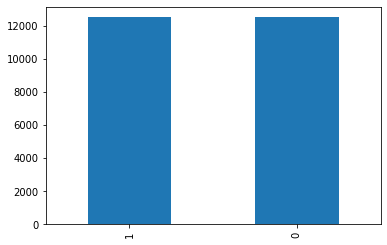

In [11]:
df['category'].value_counts().plot.bar()

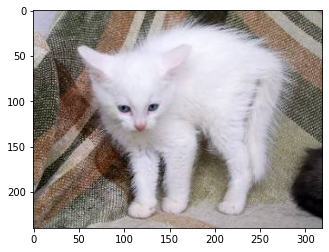

In [12]:
sample =  random.choice(filenames)
image = load_img("./train/" +sample)
plt.imshow(image)

In [13]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(182, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [0]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [0]:
earlystop = EarlyStopping(patience=10)

In [0]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [0]:
callbacks = [earlystop, learning_rate_reduction]

In [0]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

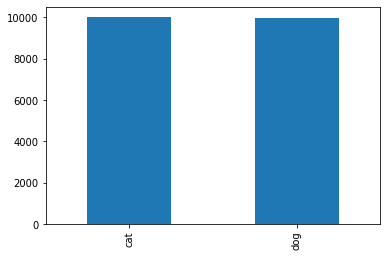

In [20]:

train_df['category'].value_counts().plot.bar()

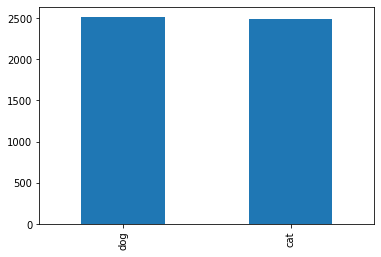

In [21]:
validate_df['category'].value_counts().plot.bar()

In [0]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [23]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    ".//train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [24]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    ".//train",
    x_col = 'filename',
    y_col = 'category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


In [25]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    ".//train",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


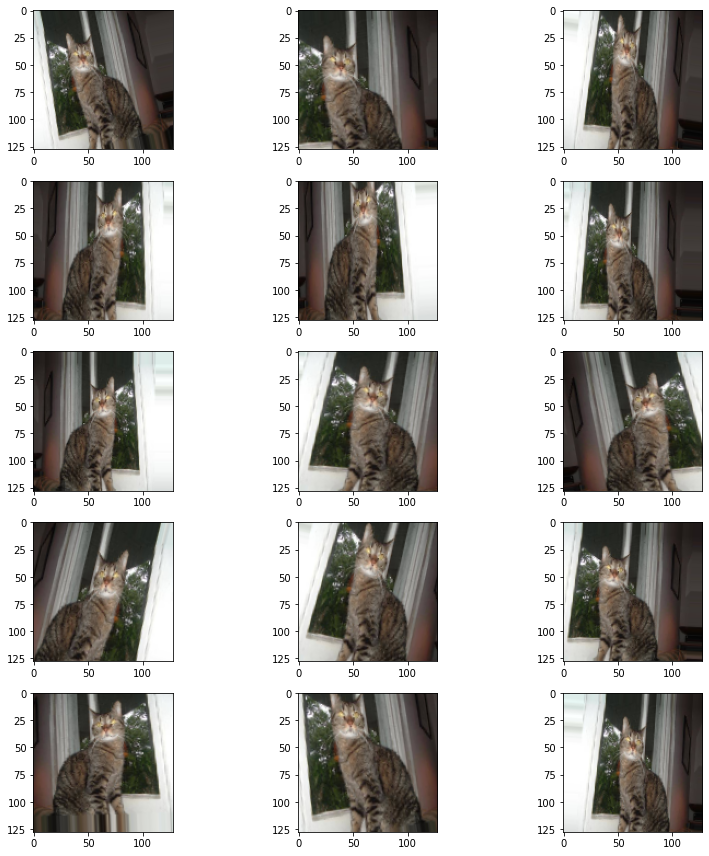

In [26]:
plt.figure(figsize=(12,12))
for i in range(0, 15):
  plt.subplot(5, 3, i+1)
  for x_batch, y_batch in example_generator:
    image = x_batch[0]
    plt.imshow(image)
    break
plt.tight_layout()
plt.show()

In [29]:
epochs=15 #평균30
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size
)

Epoch 1/15
 151/1333 [==>...........................] - ETA: 35:54 - loss: 0.5624 - accuracy: 0.7121

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 861 could not be retrieved. It could be because a worker has died.
  UserWarning)


1332/1333 [============================>.] - ETA: 1s - loss: 0.5500 - accuracy: 0.7297

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:616: UserWarning: The input 54 could not be retrieved. It could be because a worker has died.
  UserWarning)


1333/1333 [==============================] - 3876s 3s/step - loss: 0.5502 - accuracy: 0.7296 - val_loss: 0.6103 - val_accuracy: 0.7706
Epoch 2/15
1333/1333 [==============================] - 1341s 1s/step - loss: 0.5029 - accuracy: 0.7610 - val_loss: 0.4372 - val_accuracy: 0.7488
Epoch 3/15
1333/1333 [==============================] - 1341s 1s/step - loss: 0.4623 - accuracy: 0.7860 - val_loss: 0.1980 - val_accuracy: 0.8285
Epoch 4/15
1333/1333 [==============================] - 1337s 1s/step - loss: 0.4398 - accuracy: 0.7961 - val_loss: 0.4717 - val_accuracy: 0.7918
Epoch 5/15
1333/1333 [==============================] - 1337s 1s/step - loss: 0.4175 - accuracy: 0.8104 - val_loss: 0.1801 - val_accuracy: 0.8277
Epoch 6/15
1333/1333 [==============================] - 1336s 1s/step - loss: 0.4077 - accuracy: 0.8196 - val_loss: 0.4614 - val_accuracy: 0.7992
Epoch 7/15
1333/1333 [==============================] - 1328s 996ms/step - loss: 0.3896 - accuracy: 0.8300 - val_loss: 0.3561 - val_acc

In [0]:
model.save_weights("model.h5")

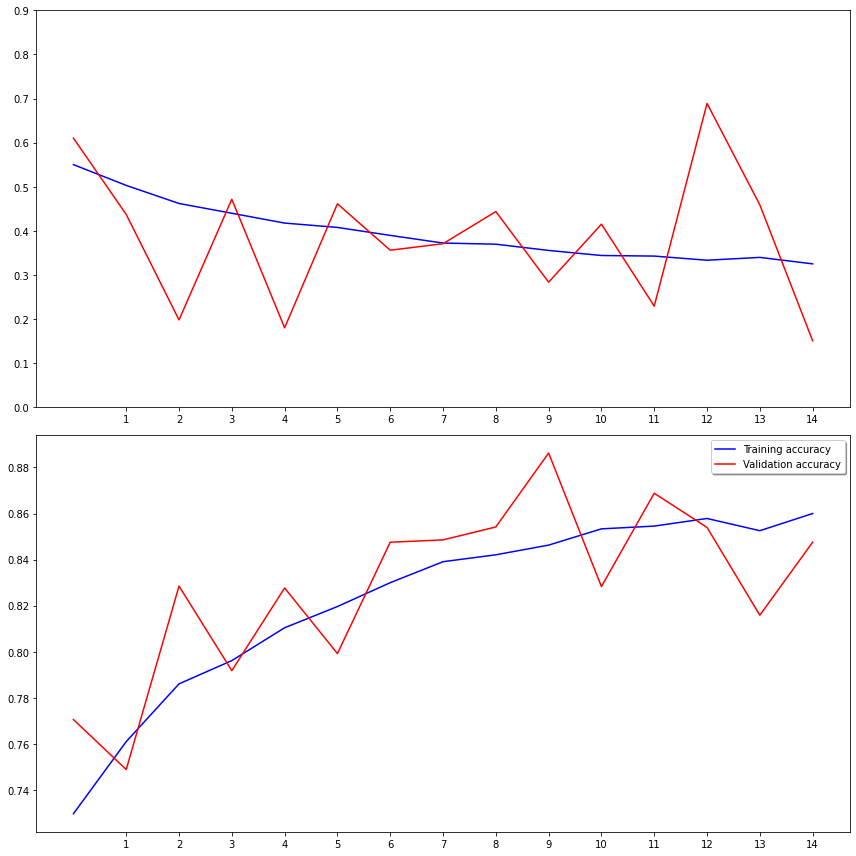

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label='Training accuracy')
ax2.plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [0]:
test_filenames = os.listdir(".//test1")
test_df = pd.DataFrame({
    'filename' : test_filenames
})
nb_samples =test_df.shape[0]

In [45]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    ".//test1",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
) 

Found 12500 validated image filenames.


In [1]:
predict =  model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

NameError: ignored

In [53]:
tset_df['category'] = np.argmax(predict, axis=-1)

NameError: ignored

In [0]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [0]:
test_df['category'] = test_df['category'].replace({'dog':1, 'cat':0})

In [0]:
test_df['category'].value_counts().plot.bar()

In [0]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test. lterrows():
  filename =  row['filename']
  category = row['category']
  img = load_img("./input/test"+filename, target_size=IMAGE_SIZE)
  plt.subplot(6, 3, index+1)
  plt.imshow(img)
  plt.xlabel(filename+ '('+ "{}", format(category)+') ')
plt.tight_layout()
plt.show()

In [0]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split(',')
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)